/home/root123/.local/lib/python3.10/site-packages/setuptools/_distutils/_msvccompiler.py:12: UserWarning: _get_vc_env is private; find an alternative (pypa/distutils#340)
  warnings.warn(
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]


Aggregation 0.00 → Peak response 0.600
Aggregation 0.25 → Peak response 0.450
Aggregation 0.50 → Peak response 0.321


INFO       No numerical integration method specified for group 'synapses_1', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses', using method 'exact' (took 0.01s). [brian2.stateupdaters.base.method_choice]


Aggregation 0.75 → Peak response 0.183
Aggregation 1.00 → Peak response 0.000


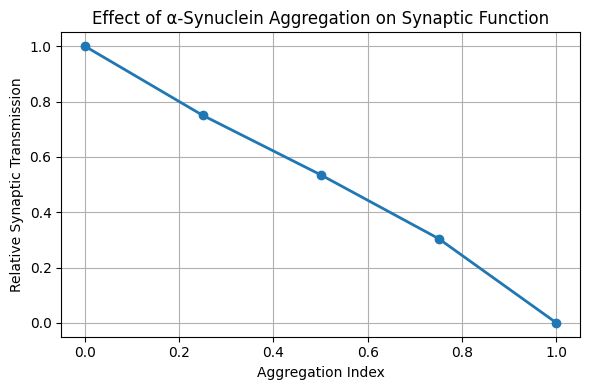

In [1]:
from brian2 import *
import matplotlib.pyplot as plt
import numpy as np
import os

# Force matplotlib to render in notebooks / SSH
%matplotlib inline

# -----------------------------
# Setup
# -----------------------------
if not os.path.exists('../figures'):
    os.makedirs('../figures')

aggregation_values = [0.0, 0.25, 0.5, 0.75, 1.0]
transmission_strength = []

# -----------------------------
# Sweep aggregation levels
# -----------------------------
for A in aggregation_values:

    # IMPORTANT: reset Brian2 each run
    start_scope()

    # ---- Biological mapping ----
    Pr_effect = 0.6 * (1 - A)
    tau_rec_effect = 800*ms * (1 + A)

    # ---- Presynaptic neuron ----
    source = SpikeGeneratorGroup(
        1,
        indices=[0, 0],
        times=[10, 20] * ms
    )

    # ---- Postsynaptic neuron ----
    post = NeuronGroup(
        1,
        'dv/dt = -v/(10*ms) : 1',
        method='exact'
    )

    # ---- Synapse with short-term depression ----
    S = Synapses(
        source,
        post,
        '''
        dx/dt = (1 - x)/tau_rec_effect : 1 (clock-driven)
        ''',
        on_pre='''
        v_post += Pr_effect * x
        x -= Pr_effect * x
        '''
    )

    S.connect()
    S.x = 1.0

    # ---- Record voltage ----
    M = StateMonitor(post, 'v', record=True)

    # ---- Run ----
    run(50*ms)

    # ---- Measure peak response ----
    peak_response = np.max(M.v[0])
    transmission_strength.append(peak_response)

    print(f"Aggregation {A:.2f} → Peak response {peak_response:.3f}")

# -----------------------------
# Normalize
# -----------------------------
transmission_strength = np.array(transmission_strength)

# Avoid divide-by-zero just in case
if transmission_strength[0] > 0:
    transmission_strength /= transmission_strength[0]

# -----------------------------
# Plot
# -----------------------------
plt.figure(figsize=(6, 4))
plt.plot(
    aggregation_values,
    transmission_strength,
    marker='o',
    linewidth=2
)

plt.xlabel('Aggregation Index')
plt.ylabel('Relative Synaptic Transmission')
plt.title('Effect of α-Synuclein Aggregation on Synaptic Function')
plt.grid(True)
plt.tight_layout()
plt.savefig('../figures/03_aggregation_sweep.png')
plt.show()
